# SFT Fine Tune on using <think> & <circle> tags

This notebook quickly finetunes the dataset on the SFT test. Accuracies are definetly not saturated after this (hover around 30% on the test set), which makes it a good candidate for GRPO.

In [4]:
import torch as T
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import get_peft_model, LoraConfig, TaskType
from torch.utils.data import DataLoader
from dataset import ReasoningHashDataset
from tqdm import tqdm
import random

# Model and tokenizer initialization
model_name = "Qwen/Qwen2.5-1.5B"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=T.bfloat16
)

# Configure PEFT
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=64,
    lora_alpha=128,
    lora_dropout=0.1,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"]
)

# Create PEFT model
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

# Dataset and DataLoader setup
train_dataset = ReasoningHashDataset(
    tokenizer=tokenizer,
    num_samples=10000,  # Small number for testing
    hash_length=4,  # Shorter hashes for testing
    chains=[2, 3, 4, 5, 6],  # Simpler chain lengths
    vary_hash=True,
    num_chains=3,
    device=model.device,
    rl=False
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
)

def add_random_eos_padding(input_ids, attention_mask, tokenizer, max_pad_tokens=10):
    """
    Adds random number of EOS tokens to the left side of the batch.
    
    Args:
        input_ids (torch.Tensor): Input token ids [batch_size, seq_len]
        attention_mask (torch.Tensor): Attention mask [batch_size, seq_len]
        tokenizer: The tokenizer object
        max_pad_tokens (int): Maximum number of padding tokens to add
    
    Returns:
        tuple: (padded_input_ids, padded_attention_mask)
    """
    batch_size, seq_len = input_ids.shape
    device = input_ids.device
    
    # Generate random padding lengths for each item in batch
    pad_lengths = [random.randint(0, max_pad_tokens) for _ in range(batch_size)]
    max_pad_len = max(pad_lengths)
    
    # Create new tensors with space for padding
    new_seq_len = seq_len + max_pad_len
    padded_input_ids = T.full((batch_size, new_seq_len), 
                             tokenizer.eos_token_id, 
                             dtype=input_ids.dtype,
                             device=device)
    padded_attention_mask = T.zeros((batch_size, new_seq_len), 
                                  dtype=attention_mask.dtype,
                                  device=device)
    
    # Fill in the original sequences with their individual padding
    for i in range(batch_size):
        pad_len = pad_lengths[i]
        padded_input_ids[i, pad_len:pad_len + seq_len] = input_ids[i]
        padded_attention_mask[i, pad_len:pad_len + seq_len] = attention_mask[i]
    
    return padded_input_ids, padded_attention_mask

# Training setup
optimizer = T.optim.AdamW(model.parameters(), lr=1e-4)
num_epochs = 1
losses = []

# Training loop
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}")
    
    for batch in progress_bar:
        input_ids = batch["input"]["input_ids"]
        attention_mask = batch["input"]["attention_mask"]
        
        # Use padded_input_ids as labels for language modeling
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=input_ids
        )
        
        loss = outputs.loss
        total_loss += loss.item()
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        progress_bar.set_postfix({"loss": loss.item()})
    
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1} average loss: {avg_loss:.4f}")

trainable params: 17,432,576 || all params: 1,561,146,880 || trainable%: 1.1167


Epoch 1: 100%|██████████| 313/313 [02:00<00:00,  2.59it/s, loss=0.825]

Epoch 1 average loss: 0.9150


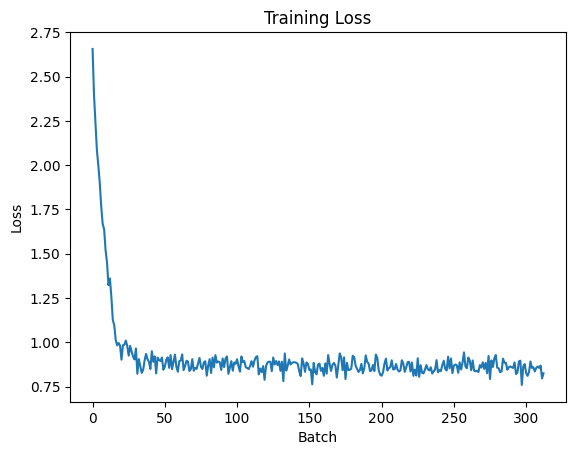

In [5]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [6]:
# Merge and save the full model
save_path = "model_checkpoint_sft4"
merged_model = model.merge_and_unload()
merged_model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print(f"Saved adapter to {save_path}_adapter")
print(f"Saved merged model and tokenizer to {save_path}")

Saved adapter to model_checkpoint_sft4_adapter
Saved merged model and tokenizer to model_checkpoint_sft4
